# imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import os
import matplotlib.style
from pandas.core.common import flatten
from functools import partial, reduce

In [2]:
plt.style.use('ggplot')

In [3]:
df=pd.read_csv('../src1/data/EODHD_EURUSD_HISTORICAL_2019_2024_1min.csv')
df.columns=['Date','Open','High','Low','Close','Volume'] 
df.set_index('Date', inplace=True)
print(df.head(2))

                        Open     High      Low    Close  Volume
Date                                                           
2019-01-02 00:25:00  1.14573  1.14574  1.14565  1.14565     128
2019-01-02 00:26:00  1.14565  1.14571  1.14564  1.14568      97


In [4]:
def average_bar_size(df):
    df = df.copy()
    df['candle_size'] = df['High'] - df['Low']
    df['average_bar'] = df['candle_size'].rolling(20).mean()
    return df

def small_wick(df, wick_size):
    df = df.copy()
    df['small_wick'] = np.where((df['Close'] > df['Open']) \
                               & ((df['High'] - df['Close']) <= ((df['High'] - df['Low']) * wick_size)) \
                               & ((df['Open'] - df['Low']) <= ((df['High'] - df['Low']) * wick_size)) \
                               | (df['Close'] < df['Open']) \
                               & ((df['High'] - df['Open']) <= ((df['High'] - df['Low']) * wick_size)) \
                               & ((df['Close'] - df['Low']) <= ((df['High'] - df['Low']) * wick_size)), True, False)
    return df

def ATR(df, n):
    df = df.copy()
    df['High-Low'] = abs(df['High'] - df['Low'])
    df['High-PrevClose'] = abs(df['High'] - df['Close'].shift(1))
    df['Low-PrevClose'] = abs(df['Low'] - df['Close'].shift(1))
    df['TR'] = df[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis = 1, skipna = False)
    df['ATR'] = df['TR'].rolling(n).mean()
    df = df.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose'], axis = 1)
    return df

def CAGR(df, source_df):
    df = df.copy()
    n = len(source_df) / (252*24)
    return round((((df['cum_res'][-1] / account_size)**(1/n)) - 1) * 100, 1)

def sharpe_ratio(df):
    df = df.copy()
    returns = df['cum_res'].pct_change()
    volatility = returns.std() * np.sqrt(252)
    return round((returns.mean() - 0.02) / volatility, 2)

def max_drawdown(df):
    df = df.copy()
    cum_returns = (1 + df['cum_res']).cumprod()
    drawdown = 1 - df['cum_res'].div(df['cum_res'].cummax())
    return round(max(drawdown.expanding().max() * 100), 2)

In [5]:
#Strategy parameters
account_size = 10000
slippage = 2
size = 1
ATR_SL = 0.5
df['ATR'] = ATR(df, 20)['ATR']
df['average_bar'] = average_bar_size(df)['average_bar']
df['small_wick'] = small_wick(df, 0.2)['small_wick']
df['spread'] = float(slippage) / float(10000)
df['size'] = float(size) * float(10000)



In [6]:
df

,Open,High,Low,Close,Volume,ATR,average_bar,small_wick,spread,size
Date,,,,,,,,,,
2019-01-02 00:25:00,1.14573,1.14574,1.14565,1.14565,128,NaN,NaN,True,0.0002,10000.0
2019-01-02 00:26:00,1.14565,1.14571,1.14564,1.14568,97,NaN,NaN,False,0.0002,10000.0
2019-01-02 00:27:00,1.14567,1.14581,1.14562,1.14578,88,NaN,NaN,False,0.0002,10000.0
2019-01-02 00:28:00,1.14577,1.14579,1.14572,1.14575,52,NaN,NaN,False,0.0002,10000.0
2019-01-02 00:29:00,1.14575,1.14581,1.14573,1.14579,71,NaN,NaN,False,0.0002,10000.0
...,...,...,...,...,...,...,...,...,...,...
2023-12-29 21:56:00,1.10388,1.10390,1.10230,1.10230,60,0.000347,0.000347,True,0.0002,10000.0
2023-12-29 21:57:00,1.10360,1.10390,1.10230,1.10390,11,0.000417,0.000417,False,0.0002,10000.0
2023-12-29 21:58:00,1.10359,1.10409,1.10353,1.10360,16,0.000435,0.000435,False,0.0002,10000.0


In [7]:
# Initialize variables for a single pair
open_trade = []
trade = {}
long_take_profit = []
short_take_profit = []
long_stop_loss = []
short_stop_loss = []
long_entry_price = []
short_entry_price = []

# Assuming df is your DataFrame for the single pair
for i in range(50, len(df)):
    # Buy
    if (df['High'][i - 1] - df['Low'][i - 1]) >= 4 * df['average_bar'][i - 1] and df['small_wick'][i - 1] == True \
        and df['Close'][i - 1] > df['Open'][i - 1] and len(open_trade) == 0:
        print(i, 'New Long trade at price:', round(df['Close'][i], 4), ' On day:', df.index[i])
        trade[i] = {'ID': i,
                    'date_of_trade': df.index[i],
                    'entry_price': df['Close'][i],
                    'signal': 'Buy',
                    'result': 0, 
                    'TP': df['Close'][i] + df['ATR'][i] * 4 * ATR_SL,
                    'SL': df['Close'][i] - df['ATR'][i] * ATR_SL}
        open_trade.append(i)
        long_take_profit.append(trade[i]['TP'])
        long_stop_loss.append(trade[i]['SL'])
        long_entry_price.append(trade[i]['entry_price'])
    
    # Sell
    if (df['High'][i - 1] - df['Low'][i - 1]) >= 4 * df['average_bar'][i - 1] and df['small_wick'][i - 1] == True \
        and df['Close'][i - 1] < df['Open'][i - 1] and len(open_trade) == 0:
        print(i, 'New Short trade at price:', round(df['Close'][i], 4), ' On day:', df.index[i])
        trade[i] = {'ID': i,
                    'date_of_trade': df.index[i],
                    'entry_price': df['Close'][i],
                    'signal': 'Sell',
                    'result': 0, 
                    'TP': df['Close'][i] - df['ATR'][i] * 4 * ATR_SL,
                    'SL': df['Close'][i] + df['ATR'][i] * ATR_SL}
        open_trade.append(i)
        short_take_profit.append(trade[i]['TP'])
        short_stop_loss.append(trade[i]['SL'])
        short_entry_price.append(trade[i]['entry_price'])
        
    # Exit trades---------------------------------------------------------------------------
    # Buy profit
    if any(y <= df['Close'][i] for y in long_take_profit):
        for j in open_trade:
            if trade[j].get('result', {}) == 0 and trade[j].get('signal', {}) == 'Buy':
                if df['Close'][i] >= trade[j]['TP']:
                    trade[j].update({'result' : (trade[j]['TP'] - trade[j]['entry_price'] - df['spread'][i]) * df['size'][i]})
                    print(j, 
                         'Long profit at price:', round(df['Close'][i], 4),
                         'On day:', df.index[i],
                         'With profit:', round(trade[j]['result'], 4), '\n')
                    open_trade.remove(j)
                    long_take_profit.remove(trade[j]['TP'])
                    long_stop_loss.remove(trade[j]['SL'])
    # Buy loss
    if any(y >= df['Close'][i] for y in long_stop_loss):
        for j in open_trade:
            if trade[j].get('result', {}) == 0 and trade[j].get('signal', {}) == 'Buy':
                if df['Close'][i] <= trade[j]['SL']:
                    trade[j].update({'result' : (trade[j]['SL'] - trade[j]['entry_price'] - df['spread'][i]) * df['size'][i]})
                    print(j, 
                         'Long loss at price:', round(df['Close'][i], 4),
                         'On day:', df.index[i],
                         'With loss:', round(trade[j]['result'], 4), '\n')
                    open_trade.remove(j)
                    long_take_profit.remove(trade[j]['TP'])
                    long_stop_loss.remove(trade[j]['SL'])
                    
    # Sell profit
    if any(y >= df['Close'][i] for y in short_take_profit):
        for j in open_trade:
            if trade[j].get('result', {}) == 0 and trade[j].get('signal', {}) == 'Sell':
                if df['Close'][i] <= trade[j]['TP']:
                    trade[j].update({'result' : (trade[j]['entry_price'] - trade[j]['TP'] - df['spread'][i]) * df['size'][i]})
                    print(j, 
                         'Short profit at price:', round(df['Close'][i], 4),
                         'On day:', df.index[i],
                         'With profit:', round(trade[j]['result'], 4), '\n')
                    open_trade.remove(j)
                    short_take_profit.remove(trade[j]['TP'])
                    short_stop_loss.remove(trade[j]['SL'])
    # Sell loss
    if any(y <= df['Close'][i] for y in short_stop_loss):
        for j in open_trade:
            if trade[j].get('result', {}) == 0 and trade[j].get('signal', {}) == 'Sell':
                if df['Close'][i] >= trade[j]['SL']:
                    trade[j].update({'result' : (trade[j]['entry_price'] - trade[j]['SL'] - df['spread'][i]) * df['size'][i]})
                    print(j, 
                         'Short loss at price:', round(df['Close'][i], 4),
                         'On day:', df.index[i],
                         'With loss:', round(trade[j]['result'], 4), '\n')
                    open_trade.remove(j)
                    short_take_profit.remove(trade[j]['TP'])
                    short_stop_loss.remove(trade[j]['SL'])
    # Exit after time
    if len(open_trade) != 0:
        for j in open_trade:
            if (i - trade[j]['ID']) >= 12*60 and trade[j].get('result', {}) == 0 and trade[j].get('signal', {}) == 'Buy':
                trade[j].update({'result' : (df['Close'][i] - trade[j]['entry_price'] - df['spread'][i]) * df['size'][i]})
                print(j, 
                     'Long exited after 12 hours:', round(df['Close'][i], 4),
                     'On day:', df.index[i],
                     'With profit:', round(trade[j]['result'], 4), '\n')
                open_trade.remove(j)
                long_take_profit.remove(trade[j]['TP'])
                long_stop_loss.remove(trade[j]['SL'])
            elif (i - trade[j]['ID']) >= 12*60 and trade[j].get('result', {}) == 0 and trade[j].get('signal', {}) == 'Sell':
                trade[j].update({'result' : (trade[j]['entry_price'] - df['Close'][i] - df['spread'][i]) * df['size'][i]})
                print(j, 
                     'Short exited after 12 hours:', round(df['Close'][i], 4),
                     'On day:', df.index[i],
                     'With profit:', round(trade[j]['result'], 4), '\n')
                open_trade.remove(j)
                short_take_profit.remove(trade[j]['TP'])
                short_stop_loss.remove(trade[j]['SL'])

/var/folders/l0/091nq6390xb96z8313zhyp4m0000gp/T/ipykernel_24938/234745209.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (df['High'][i - 1] - df['Low'][i - 1]) >= 4 * df['average_bar'][i - 1] and df['small_wick'][i - 1] == True \
/var/folders/l0/091nq6390xb96z8313zhyp4m0000gp/T/ipykernel_24938/234745209.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if (df['High'][i - 1] - df['Low'][i - 1]) >= 4 * df['average_bar'][i - 1] and df['small_wick'][i - 1] == True \
/var/folders/l0/091nq6390xb96z8313zhyp4m0000gp/T/ipykernel_24938/234745209.py:15: FutureWarning: Series.__getitem__ treating keys as positions i

1020 New Short trade at price: 1.1338  On day: 2019-01-02 17:25:00
1020 Short profit at price: 1.1332 On day: 2019-01-02 17:28:00 With profit: 1.85 

2290 New Short trade at price: 1.1391  On day: 2019-01-03 14:36:00
2290 Short loss at price: 1.1395 On day: 2019-01-03 14:37:00 With loss: -2.72 

2445 New Short trade at price: 1.139  On day: 2019-01-03 17:11:00
2445 Short profit at price: 1.1388 On day: 2019-01-03 17:17:00 With profit: -0.15 

3925 New Long trade at price: 1.1404  On day: 2019-01-06 17:56:00
3925 Long loss at price: 1.1403 On day: 2019-01-06 17:57:00 With loss: -2.2 

4093 New Long trade at price: 1.142  On day: 2019-01-06 20:44:00
4093 Long profit at price: 1.1422 On day: 2019-01-06 20:47:00 With profit: 0.1 

4235 New Long trade at price: 1.1429  On day: 2019-01-06 23:06:00
4235 Long loss at price: 1.1428 On day: 2019-01-06 23:09:00 With loss: -2.6675 

4410 New Short trade at price: 1.1418  On day: 2019-01-07 02:01:00
4410 Short loss at price: 1.1419 On day: 2019-01-

In [8]:
# Initialize variables for a single pair
profits = []
losses = []
be = []

# Assuming trade is your dictionary for the single pair
pairs_results = pd.DataFrame.from_dict({(i, j): trade[j] for j in trade.keys()}, orient='index')
pairs_results = pairs_results.drop(['signal', 'ID', 'TP', 'SL'], axis=1)
pairs_results.set_index('date_of_trade', inplace=True)
pairs_results['cum_res'] = pairs_results['result'].cumsum() + account_size

for t in trade:
    if trade[t]['result'] > 0.1:
        profits.append(trade[t]['result'])
    elif trade[t]['result'] < -0.1:
        losses.append(trade[t]['result'])
    elif -0.1 <= trade[t]['result'] <= 0.1:
        be.append(trade[t]['result'])

# Since we have only one pair, we don't need to merge multiple DataFrames
strategy_results = pairs_results.sort_index()
strategy_results['final_res'] = strategy_results['result']
strategy_results['cum_res'] = strategy_results['final_res'].cumsum() + account_size

str_profits = profits
str_losses = losses
str_be = be

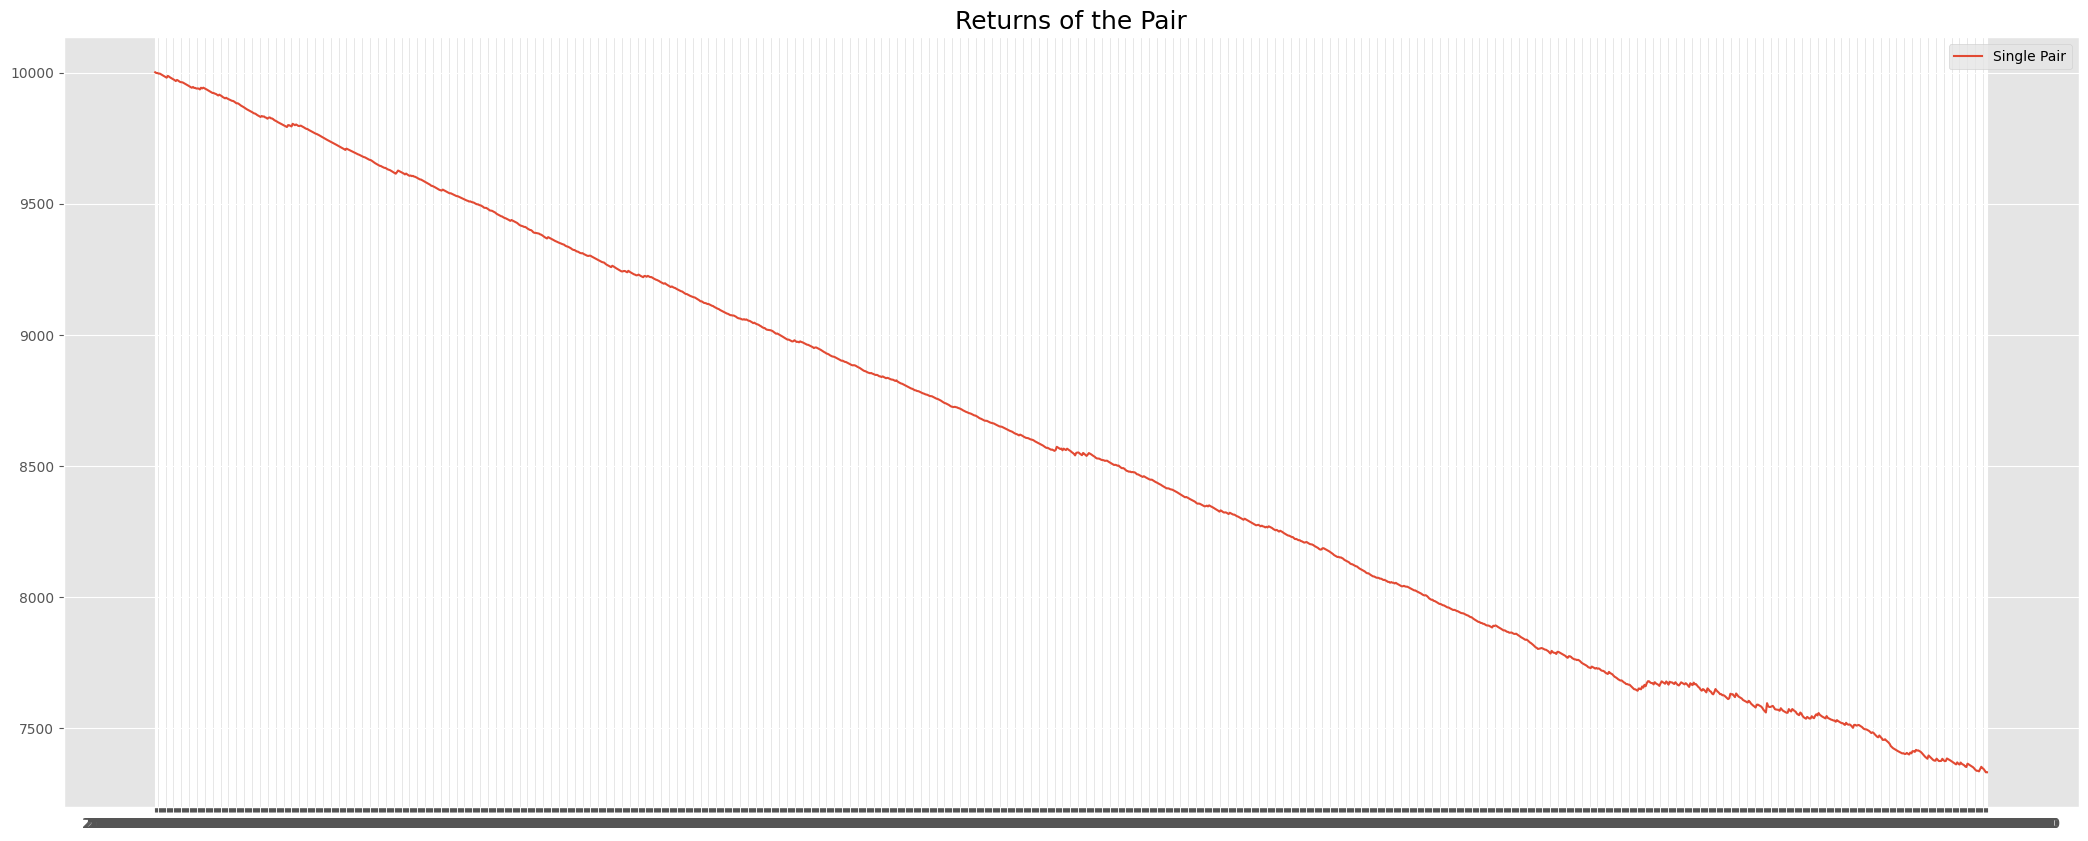

In [9]:
plt.figure(figsize=(26, 10))
plt.plot(pairs_results['cum_res'], label='Single Pair')
plt.legend()
plt.title('Returns of the Pair', fontsize=18)
plt.show()

***** STRATEGY PERFORMANCE *****
--------------------------------
CAGR: -0.1 %
Sharpe ratio: -3.37
Maximum drawdown 26.69 % 

Number of trades: 1600
Number of profits: 214
Number of losses: 1373
Number of breakevens: 13 

Winning percentage 13.48 %
ROI: -2668
--------------------------------
Average profitable trade: 4.06
Average lossing trade: -2.58
Max profitable trade: 35.6
Max lossing trade: -11.95


/var/folders/l0/091nq6390xb96z8313zhyp4m0000gp/T/ipykernel_24938/3104574441.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return round((((df['cum_res'][-1] / account_size)**(1/n)) - 1) * 100, 1)
/Users/moctader/TrustworthyAI/bt&strategy/env/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: RuntimeWarning: overflow encountered in accumulate
  return bound(*args, **kwds)
/var/folders/l0/091nq6390xb96z8313zhyp4m0000gp/T/ipykernel_24938/2471366690.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('ROI:', round(strategy_results['cum_res'][-1]) - account_size)


Text(0.5, 1.0, 'return of strategy')

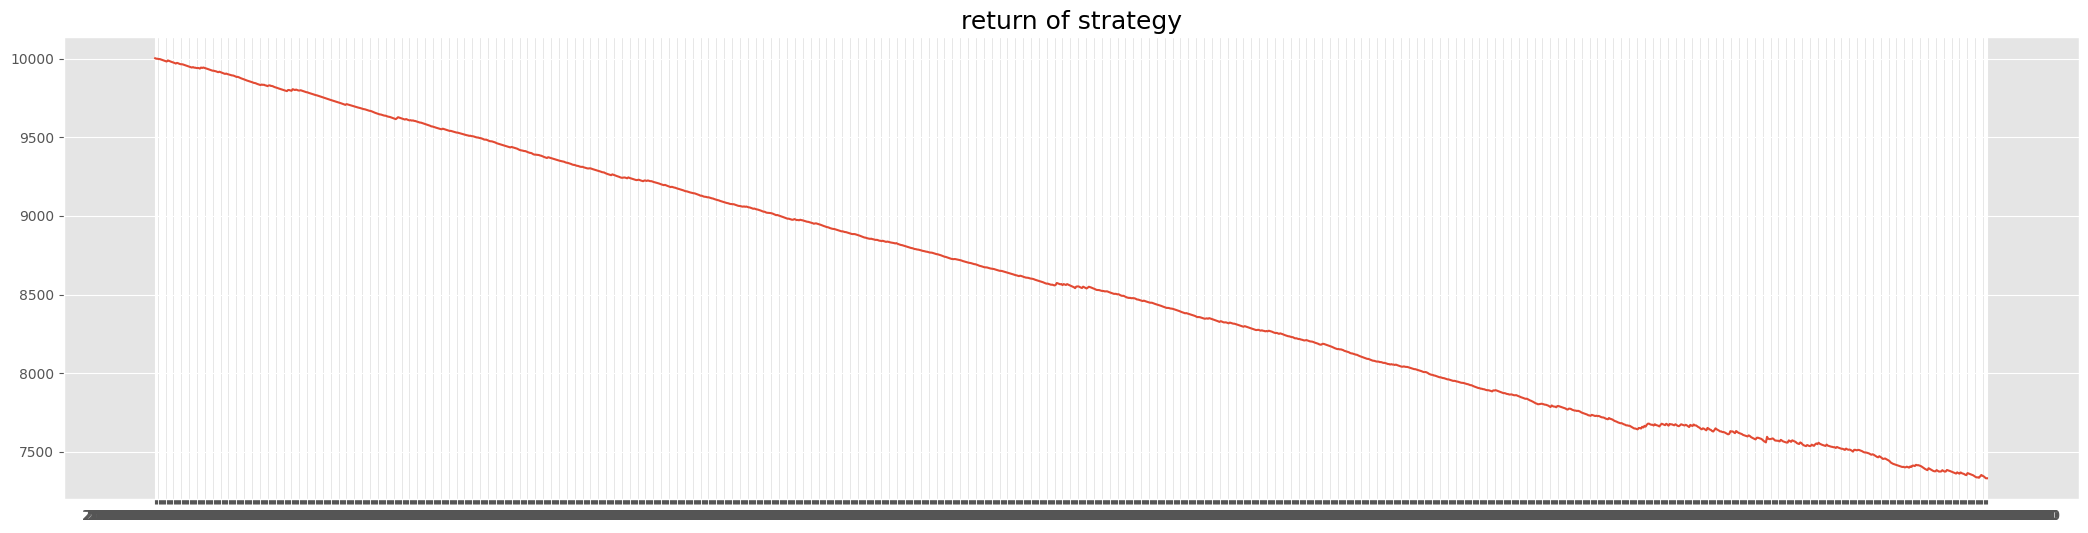

In [10]:
#Strategy performance
print('***** STRATEGY PERFORMANCE *****')
print('--------------------------------')
print('CAGR:', CAGR(strategy_results, df), '%')
print('Sharpe ratio:', sharpe_ratio(strategy_results))
print('Maximum drawdown', max_drawdown(strategy_results), '% \n')
print('Number of trades:', len(str_profits + str_losses + str_be))
print('Number of profits:', len(str_profits))
print('Number of losses:', len(str_losses))
print('Number of breakevens:', len(str_be), '\n')
print('Winning percentage', (round(len(str_profits) / (len(str_profits) + len(str_losses)) * 100, 2)), '%')
print('ROI:', round(strategy_results['cum_res'][-1]) - account_size)
print('--------------------------------')
print('Average profitable trade:', round(sum(str_profits) / len(str_profits), 2))
print('Average lossing trade:', round(sum(str_losses) / len(str_losses), 2))
print('Max profitable trade:', round(max(str_profits), 2))
print('Max lossing trade:', round(min(str_losses), 2))

plt.figure(figsize = (26, 6))
plt.plot(strategy_results['cum_res'])
plt.title('return of strategy', fontsize = 18)